#      <center> COVID-19 Data Analysis: Algeria and the World </center>

### <center> Singhealth Singapore General Hospital Take Home Exercise </center>
### <center> Ng Guangren, Ryan </center>

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

from sklearn.metrics.pairwise import nan_euclidean_distances

import sqlite3


In [54]:
df = pd.read_csv(r"Data.csv")


# Data Exploration

In [55]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38472 entries, 0 to 38471
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Entity                           38472 non-null  object 
 1   Continent                        38472 non-null  object 
 2   Latitude                         38472 non-null  float64
 3   Longitude                        38472 non-null  float64
 4   Average temperature per year     38472 non-null  int64  
 5   Hospital beds per 1000 people    38472 non-null  float64
 6   Medical doctors per 1000 people  38472 non-null  float64
 7   GDP/Capita                       38472 non-null  float64
 8   Population                       38472 non-null  int64  
 9   Median age                       38472 non-null  int64  
 10  Population aged 65 and over (%)  38472 non-null  int64  
 11  Date                             38472 non-null  object 
 12  Daily tests       

Turning object type features into string helps in narrowing down the scope. For example numbers cannot be placed in a string feature. It also allows data type specific operations.[<sup>1</sup>](https://towardsdatascience.com/why-we-need-to-use-pandas-new-string-dtype-instead-of-object-for-textual-data-6fd419842e24)

In [56]:
object_to_string = {
    'Entity': 'string',
    'Continent': 'string',
}

df = df.astype(object_to_string)
# df["Date"] = pd.to_datetime(df.Date)


In [57]:
df = df.round(3)
df


,Entity,Continent,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP/Capita,Population,Median age,Population aged 65 and over (%),Date,Daily tests,Cases,Deaths
0,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-25,8.0,NaN,NaN
1,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-26,5.0,NaN,NaN
2,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-27,4.0,NaN,NaN
3,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-28,1.0,NaN,NaN
4,Albania,Europe,41.15,20.17,14,2.89,1.29,5353.2,2873457,38,14,2020-02-29,8.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38467,Zimbabwe,Africa,-19.02,29.15,20,1.70,0.08,1464.0,16529904,19,3,2021-02-24,1804.0,35960.0,1456.0
38468,Zimbabwe,Africa,-19.02,29.15,20,1.70,0.08,1464.0,16529904,19,3,2021-02-25,2965.0,35994.0,1458.0
38469,Zimbabwe,Africa,-19.02,29.15,20,1.70,0.08,1464.0,16529904,19,3,2021-02-26,NaN,36044.0,1463.0
38470,Zimbabwe,Africa,-19.02,29.15,20,1.70,0.08,1464.0,16529904,19,3,2021-02-27,NaN,36058.0,1463.0


In [58]:
df.Entity.unique()


<StringArray>
[             'Albania',              'Algeria',            'Argentina',
              'Armenia',            'Australia',              'Austria',
              'Bahrain',           'Bangladesh',              'Belarus',
              'Belgium',
 ...
               'Turkey',               'Uganda',              'Ukraine',
 'United Arab Emirates',       'United Kingdom',        'United States',
              'Uruguay',              'Vietnam',               'Zambia',
             'Zimbabwe']
Length: 104, dtype: string

The word "Entity" is a little too generalised. I will consider them as countries as it is synonmous as sovereign states. 

In [59]:
df.rename({"Entity": "Country", "GDP/Capita": "GDP per capita"},
          inplace=True, axis=1)

In [60]:
df.isnull().sum()

Country                               0
Continent                             0
Latitude                              0
Longitude                             0
Average temperature per year          0
Hospital beds per 1000 people         0
Medical doctors per 1000 people       0
GDP per capita                        0
Population                            0
Median age                            0
Population aged 65 and over (%)       0
Date                                  0
Daily tests                        7895
Cases                               254
Deaths                             3610
dtype: int64

In [61]:
# df.groupby('Country').mean(numeric_only=True)[["Daily tests","Cases","Deaths"]].sort_values(["Daily tests","Cases","Deaths"]).head(20)


In [62]:
df.groupby('Country').mean()[["Daily tests", "Cases", "Deaths"]].isnull().any()


Daily tests    False
Cases          False
Deaths         False
dtype: bool

This cell above shows that after grouping by country, each country has at least one numerical value so calculating mean doesn't not return null.

In [77]:


for name, group in df.groupby('Country'):
    nan_e_dist = nan_euclidean_distances(group[["Daily tests"]])
    l = list(filter(lambda x: x > 0, sorted(nan_e_dist[0])))
    if len(l)==0:
        continue
    imputer = KNNImputer(n_neighbors=int(l[0]))
    x = imputer.fit_transform(X=group[["Daily tests", "Cases", "Deaths"]])

https://www.analyticsvidhya.com/blog/2020/07/knnimputer-a-robust-way-to-impute-missing-values-using-scikit-learn/

In [22]:
# imputer = SimpleImputer()
# for name, group in df.groupby('Country'):
#     group[["Daily tests", "Cases", "Deaths"]] =imputer.fit_transform(group[["Daily tests", "Cases", "Deaths"]])
#     df[df.Country == name] = group

# df.isnull().any()[lambda x: x == True]

Series([], dtype: bool)

# 5- Statistical description of the data

In [14]:
df.describe().round(2)


,Latitude,Longitude,Average temperature per year,Hospital beds per 1000 people,Medical doctors per 1000 people,GDP per capita,Population,Median age,Population aged 65 and over (%),Daily tests,Cases,Deaths
count,38472.00,38472.00,38472.00,38472.00,38472.00,38472.00,3.847200e+04,38472.00,38472.00,38472.00,38472.00,38472.00
mean,23.74,20.21,17.72,3.17,2.09,19002.33,4.896983e+07,32.75,10.66,37240.87,288139.04,8016.59
std,26.06,61.07,8.13,2.56,1.52,22271.11,1.427251e+08,8.47,6.77,141288.24,1400831.37,29114.55
min,-40.90,-106.35,-2.00,0.20,0.02,411.60,3.412840e+05,16.00,1.00,-239172.00,1.00,1.00
25%,8.62,-3.44,11.00,1.40,0.82,3659.00,4.793900e+06,27.00,5.00,1564.00,2099.00,69.00
50%,27.51,21.82,20.00,2.50,1.89,8821.80,1.148464e+07,32.00,8.00,5412.00,21982.00,490.50
75%,45.94,47.48,25.00,4.49,3.21,25946.20,4.286296e+07,41.00,16.00,20382.00,138986.75,3274.25
max,64.96,179.41,29.00,13.05,7.52,114704.60,1.339180e+09,48.00,28.00,2945871.00,28605669.00,513091.00


# Sqlite3 Setup, creations and insertions

In [15]:
from datetime import datetime

con = sqlite3.connect("db.db", detect_types=sqlite3.PARSE_DECLTYPES |
                      sqlite3.PARSE_COLNAMES)
cur = con.cursor()
cur.execute('''
DROP TABLE IF EXISTS covid19_country_data;
''')
cur.execute('''
CREATE TABLE IF NOT EXISTS covid19_country_data(
    id INTEGER PRIMARY KEY NOT NULL,
    country TEXT NOT NULL,
    continent TEXT NOT NULL,
    latitude REAL NOT NULL,
    longitude REAL NOT NULL,
    average_temperature_per_year INTEGER NOT NULL,
    hospital_beds_per_1000_people REAL NOT NULL,
    medical_doctors_per_1000_people REAL NOT NULL,
    gdp_per_capita REAL NOT NULL,
    population INTEGER NOT NULL,
    median_age INTEGER NOT NULL,
    population_aged_65_and_above_in_percentage INTEGER NOT NULL,
    date TEXT NOT NULL,
    daily_tests REAL NOT NULL,
    cases REAL NOT NULL,
    deaths REAL NOT NULL
);
''')

df.reset_index(inplace=True)
cur.executemany('''
INSERT INTO covid19_country_data VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?);
''',df.values)
con.commit()


In [16]:
t =cur.execute('''SELECT country,continent,
latitude,longitude,average_temperature_per_year,hospital_beds_per_1000_people,medical_doctors_per_1000_people,gdp_per_capita,population,median_age,population_aged_65_and_above_in_percentage,daily_tests,cases,deaths 
FROM covid19_country_data''')

df = pd.DataFrame(t.fetchall(),columns= ["country","continent","latitude","longitude","average_temperature_per_year","hospital_beds_per_1000_people","medical_doctors_per_1000_people","gdp_per_capita","population","median_age","population_aged_65_and_above_in_percentage","daily_tests","cases","deaths" ])


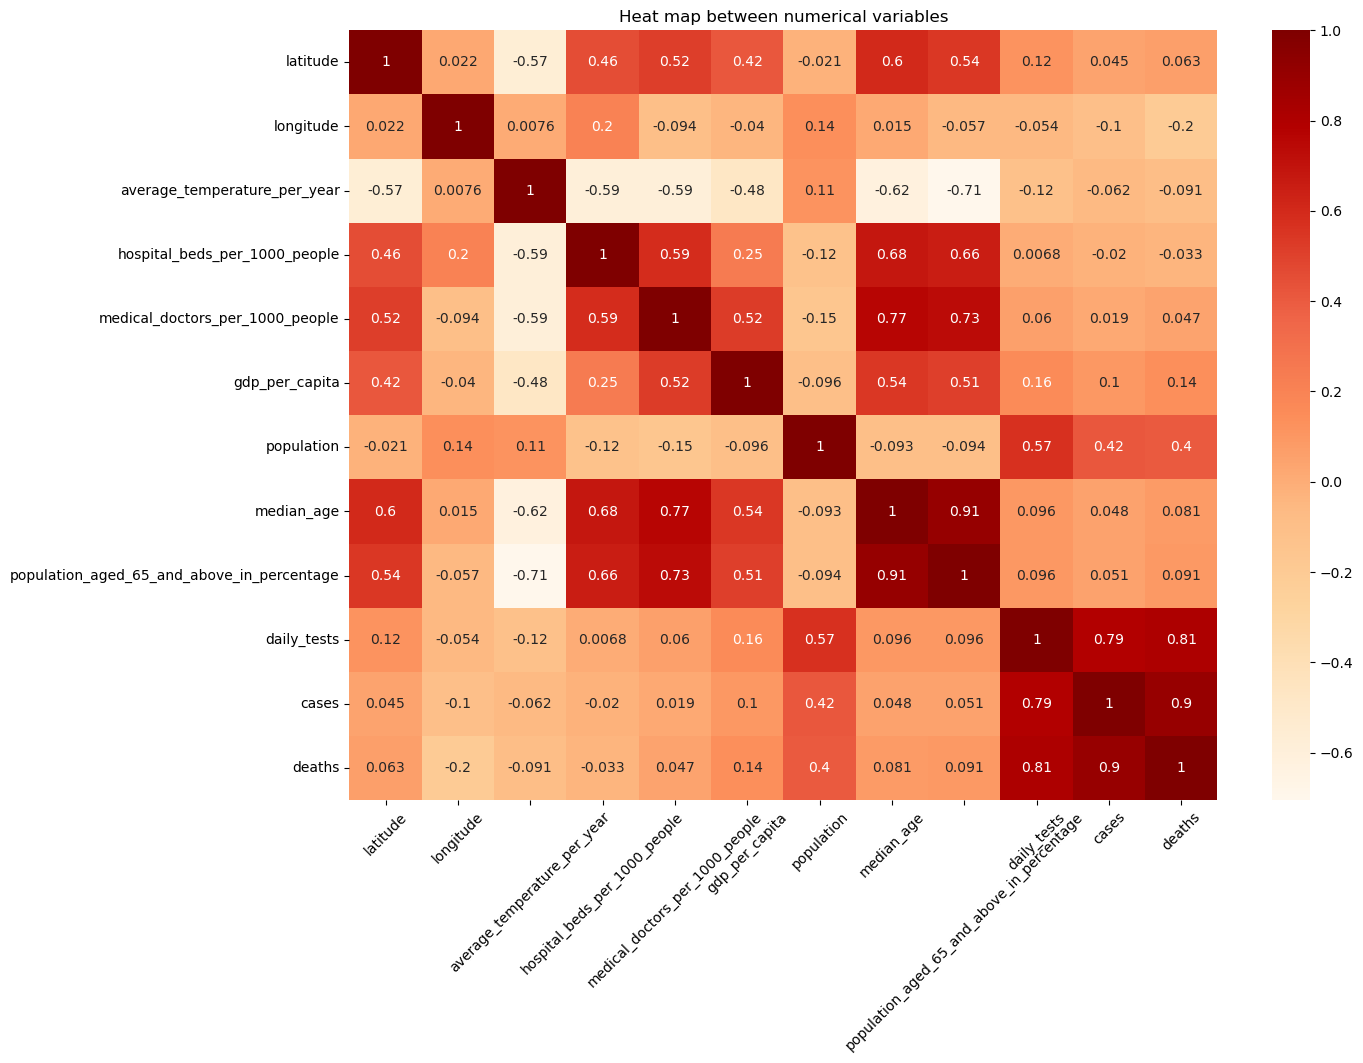

In [17]:
plt.figure(figsize=(14,10))
plt.title("Heat map between numerical variables")
sns.heatmap(df.corr(),annot=True,cmap=plt.cm.OrRd)
plt.xticks(rotation=45)
plt.show()

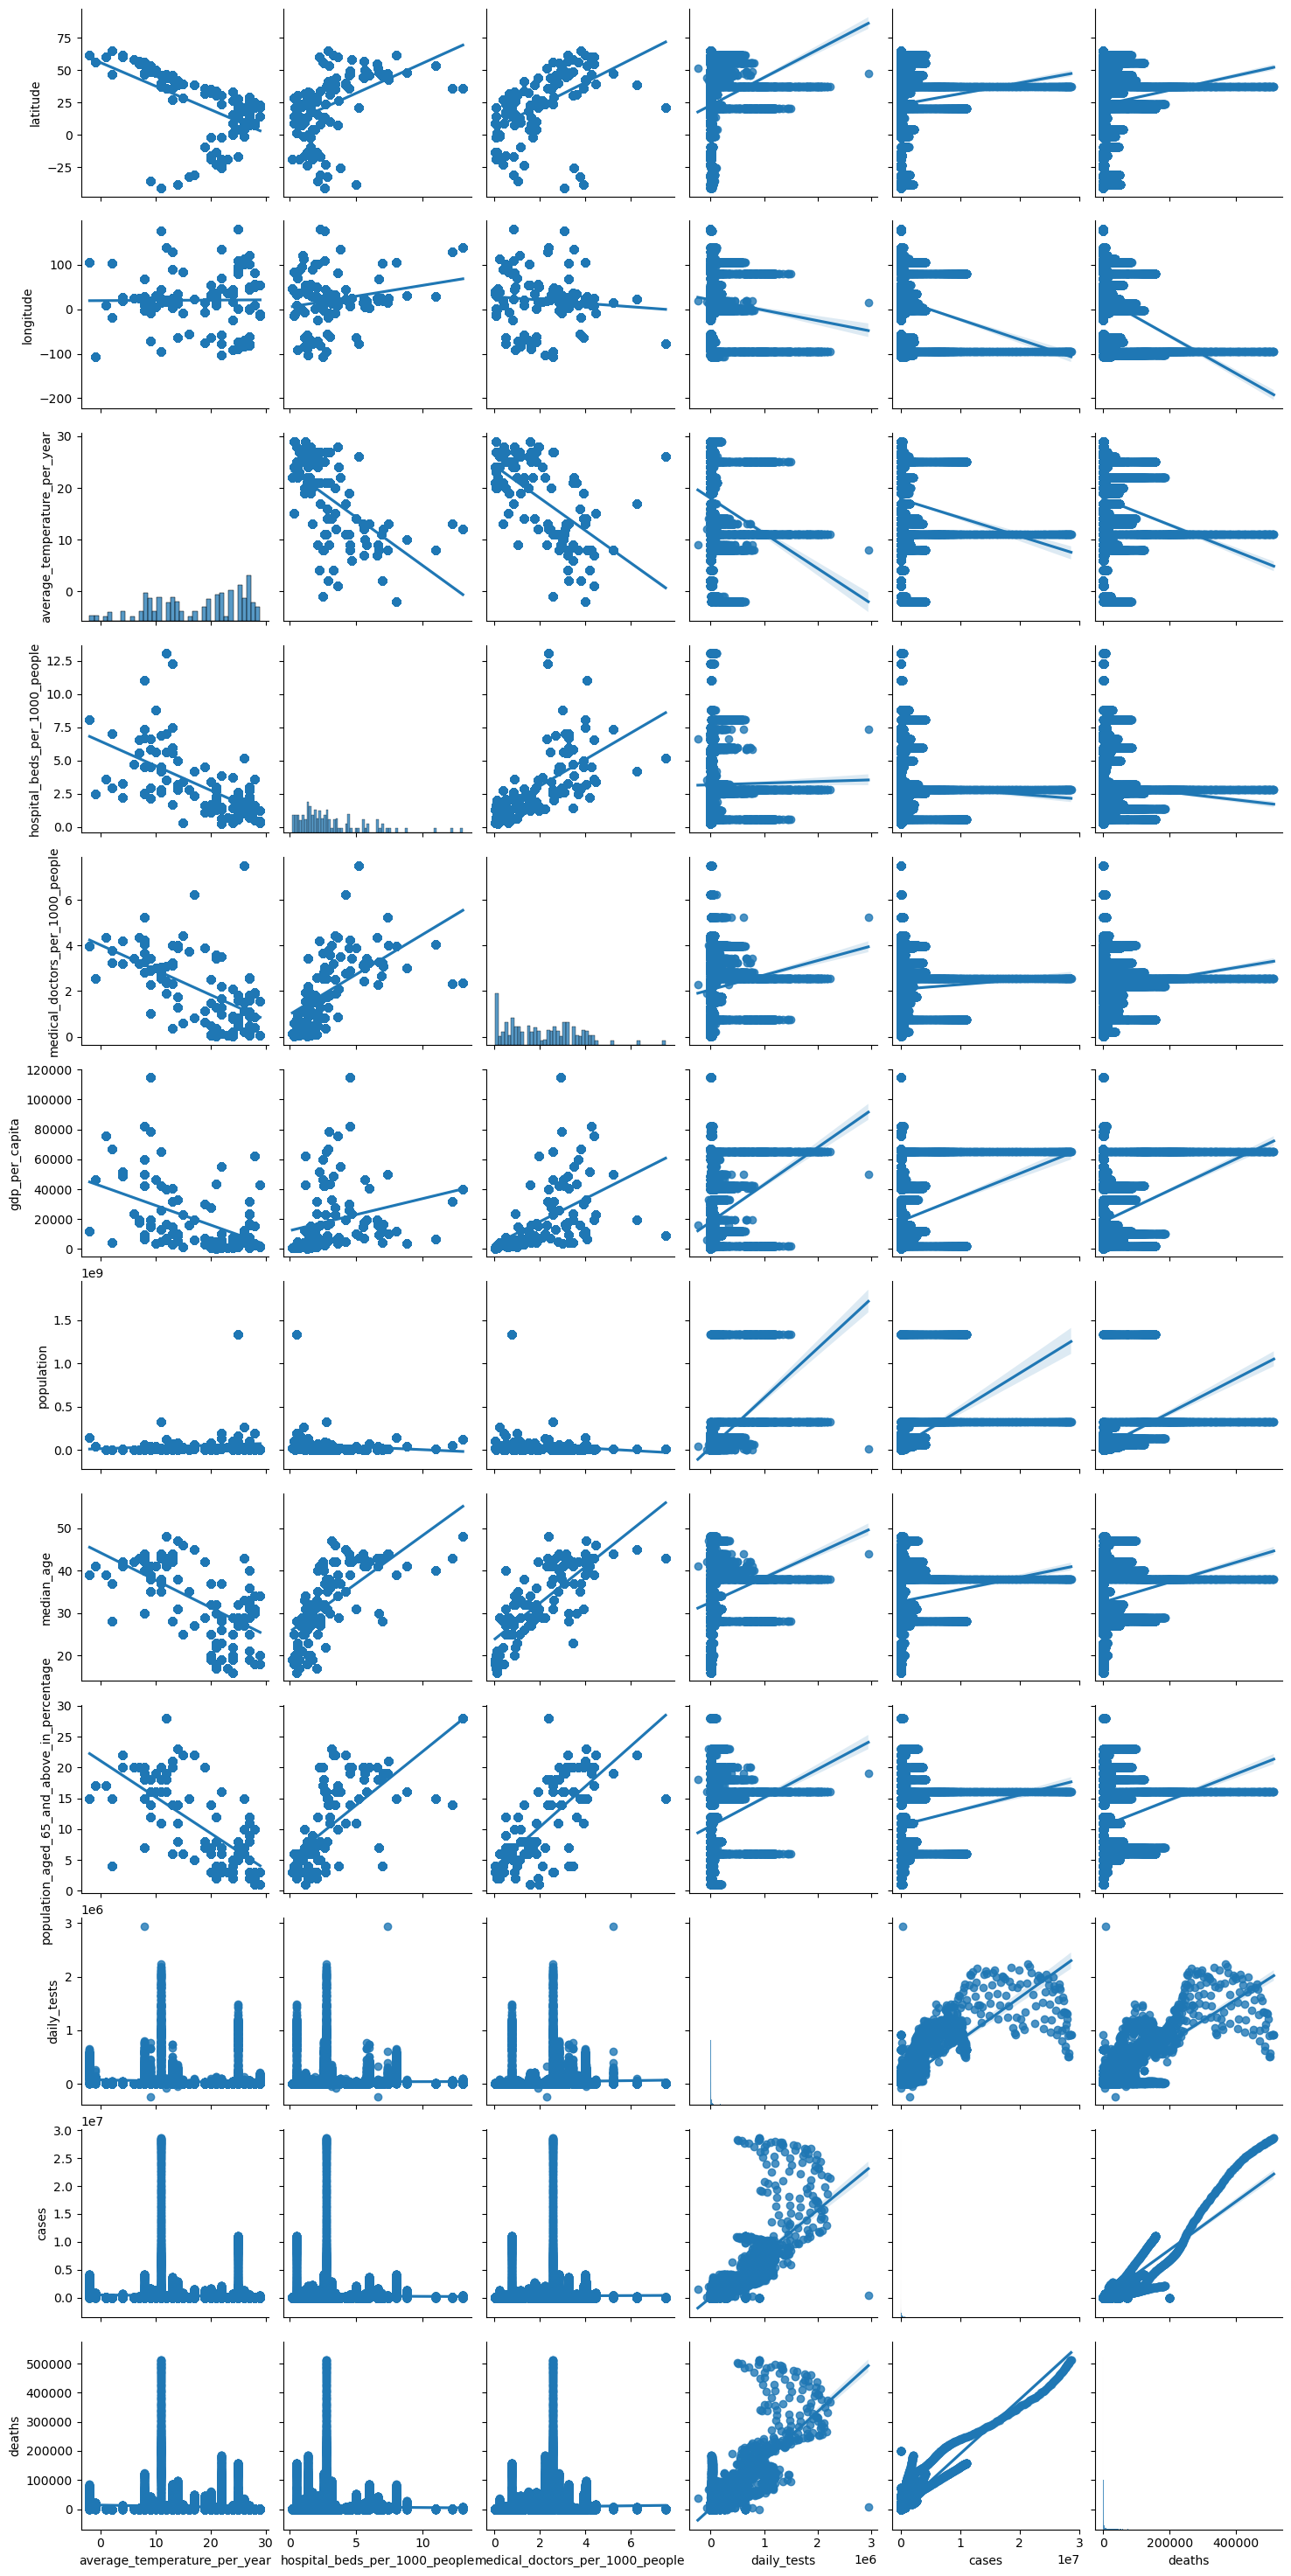

In [18]:

sns.pairplot(df,
x_vars=['average_temperature_per_year',
'hospital_beds_per_1000_people',
'medical_doctors_per_1000_people',
'daily_tests',
'cases',
'deaths'],
kind = 'reg')

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38472 entries, 0 to 38471
Data columns (total 14 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   country                                     38472 non-null  object 
 1   continent                                   38472 non-null  object 
 2   latitude                                    38472 non-null  float64
 3   longitude                                   38472 non-null  float64
 4   average_temperature_per_year                38472 non-null  int64  
 5   hospital_beds_per_1000_people               38472 non-null  float64
 6   medical_doctors_per_1000_people             38472 non-null  float64
 7   gdp_per_capita                              38472 non-null  float64
 8   population                                  38472 non-null  int64  
 9   median_age                                  38472 non-null  int64  
 10  population

In [79]:
t =cur.execute('''SELECT date,cases,country
FROM covid19_country_data''')

df = pd.DataFrame(t.fetchall(),columns= ["date","cases","country" ])
df.date = pd.to_datetime(df.date)


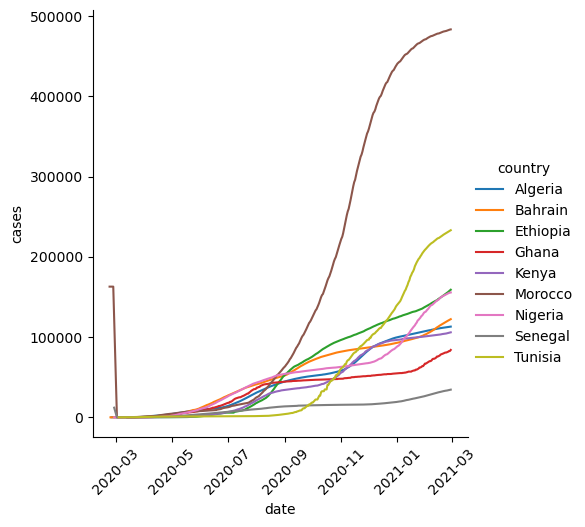

In [80]:
new_var = df.country.isin(['Algeria', 'Bahrain', 'Ethiopia', 'Ghana', 'Kenya', 'Morocco', 'Nigeria', 'Senegal', 'Tunisia'])
sns.relplot(data=df[new_var],x="date",y="cases",hue="country",kind="line")
plt.xticks(rotation=45)
plt.show()

# Close Conneciton

In [ ]:
cur.close()
con.close()